In [230]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ml_collections as mlc
import torch.nn as nn
from torch.autograd.functional import jacobian
import torch

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
df_or = pd.read_csv('https://home.treasury.gov/system/files/276/yield-curve-rates-1990-2021.csv')

In [215]:
df = df_or.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date', drop=True)
df.head()
df_diff = df.diff()
#df_diff = df.copy()
#df_diff[df.columns] = df[df.columns].values - df.mean(axis=1).values[:,None]
df_diff.head()
y = df_diff.values
index = df_diff.index

In [216]:
df_diff

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,NaN,NaN,0.06,NaN,0.05,0.04,0.07,0.06,0.05,0.06,0.05,NaN,0.04
1990-01-04,NaN,NaN,-0.05,NaN,-0.04,-0.03,-0.02,-0.03,-0.01,-0.02,-0.01,NaN,0.00
1990-01-05,NaN,NaN,-0.05,NaN,-0.05,-0.03,-0.02,0.01,0.01,0.01,0.01,NaN,0.02
1990-01-08,NaN,NaN,0.00,NaN,0.03,0.02,0.00,0.01,0.00,0.02,0.03,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.00,0.00,-0.01,NaN,0.03,0.02,0.05,0.01,0.01,-0.01,-0.02,-0.02,-0.03
2021-12-28,-0.01,-0.01,0.00,NaN,-0.01,0.06,-0.02,0.01,0.01,0.00,0.01,0.02,0.02
2021-12-29,-0.02,-0.02,-0.01,NaN,-0.01,-0.01,0.01,0.00,0.02,0.06,0.06,0.06,0.06


<Axes: xlabel='Date'>

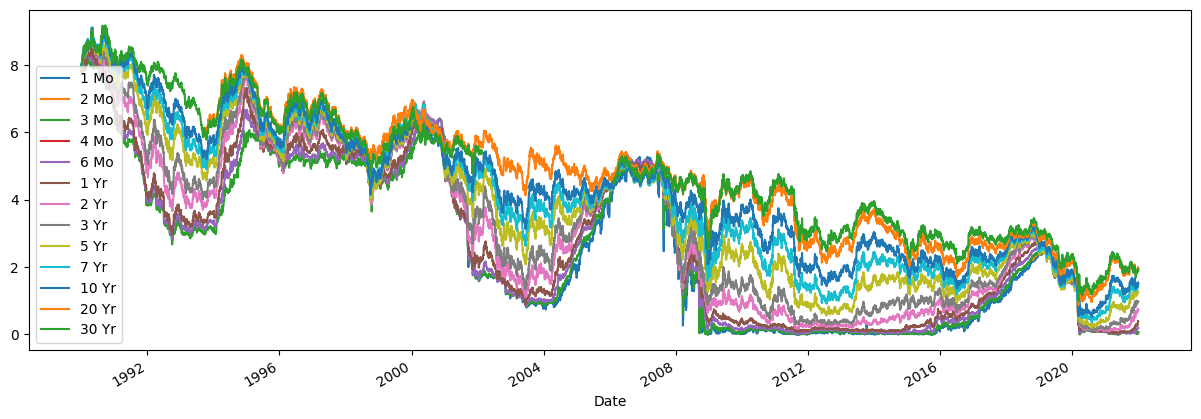

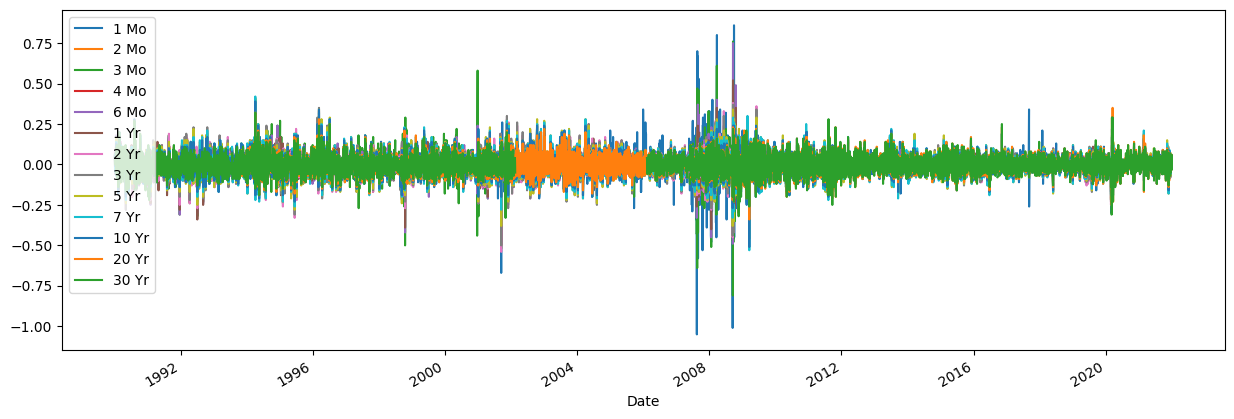

In [217]:
df.plot(figsize=(15,5))
df_diff.plot(figsize=(15,5))

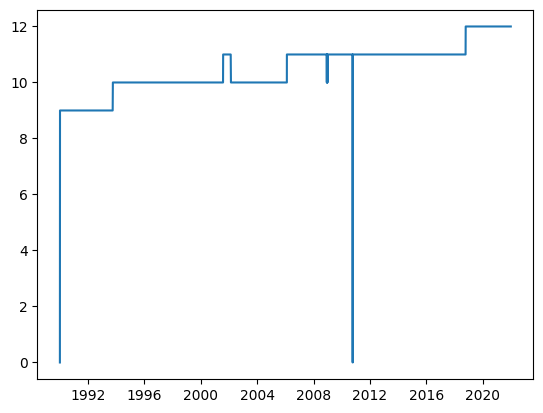

In [218]:
mask = (~np.isnan(y)).astype('float64')
plt.plot(index, mask.sum(axis=1))

## Config

In [219]:
print(y.shape)

(8008, 13)


(5000, 11) (1000, 11) (2008, 11)


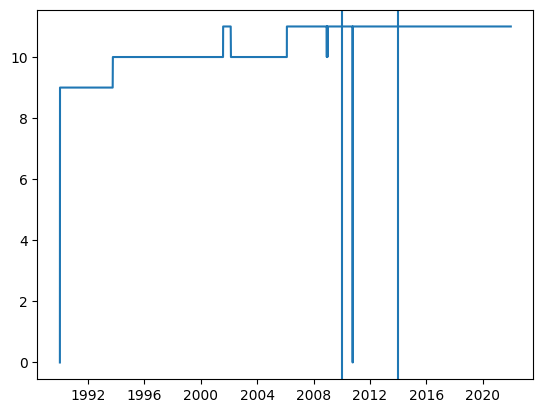

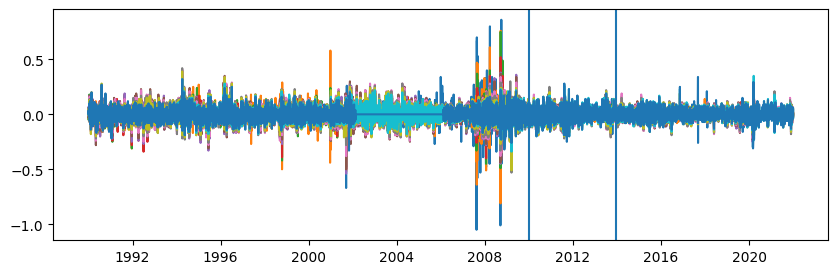

In [220]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 3
cfg.obs_dim = y.shape[1]
cfg.p_factor = 1
cfg.p_eps = 0
cfg.T_train = 5000
cfg.T_test = 2008
cfg.T_val = 1000
cfg.T = y.shape[0] #8008

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25

series_use = np.argwhere((mask[:cfg.T_train]==1).any(axis=0))[:,0]
y_use = y[:, series_use]
y_use = np.where(np.isnan(y_use), 0, y_use)
mask_use = mask[:,series_use]

#Create train test val
y_train = y_use[0:cfg.T_train]
y_val = y_use[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y_use[cfg.T_train+cfg.T_val:]

weights_train = mask_use[0:cfg.T_train]
weights_val = mask_use[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask_use.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

plt.figure(figsize=(10,3))
plt.plot(index, y_use)
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [222]:
cfg.lr = 0.0001
cfg.max_iter = 100
cfg.n_epochs = 10
cfg.factor_dim = 3
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim,4,6,8, cfg.obs_dim], activation=nn.Sigmoid(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim,  8,6,4, cfg.factor_dim], activation=nn.Sigmoid(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 394
torch.Size([5000, 11]) torch.Size([1000, 11])
1 1.004038845657543456575437
2 0.007201384901288588012885885
3 0.007266868009665020096650255
4 0.007449972330574777305747775
5 0.00727389260064691900646919
6 0.007256988633222356332223565
7 0.007133872618981797589817975
8 0.007172942146730081467300814
9 0.007227525482796564827965645
10 0.0071873506827718892771889
11 0.00706580428667603866760385
12 0.00709251208070689307068935
13 0.00661014480320558832055886
14 0.00542870139003179600317965
15 0.00400330579044767904476656
16 0.00316835213660197366019737
17 0.00281668876692249339224933
18 0.00253528097991469769146976
19 0.00234883521968249676824967
20 0.00225488313660618866061886
21 0.00217205887826479982647993
22 0.00212074824457596625759662
23 0.00211507198030046803004656
24 0.00204773728808411860841186
25 0.00204583350235335323533538
26 0.00201088243466653666665366
27 0.00204107559369105846910584
28 0.00200379057194159669415966
29 0.00200624641358769335876

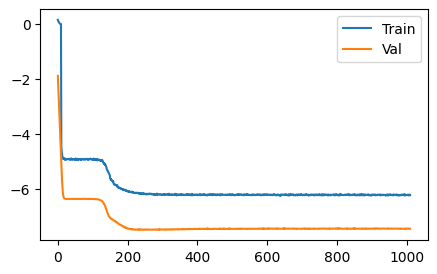

In [223]:
plot_train_hist(train_hist=train_hist, log=True)

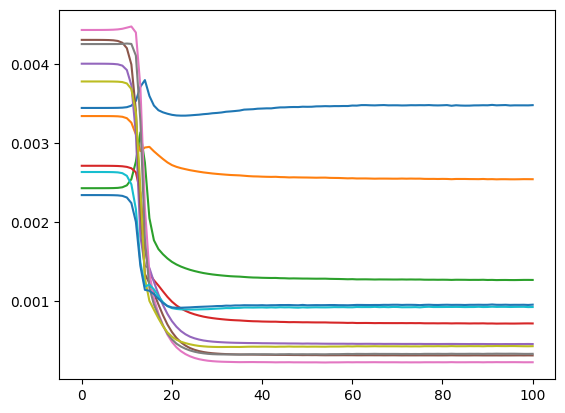

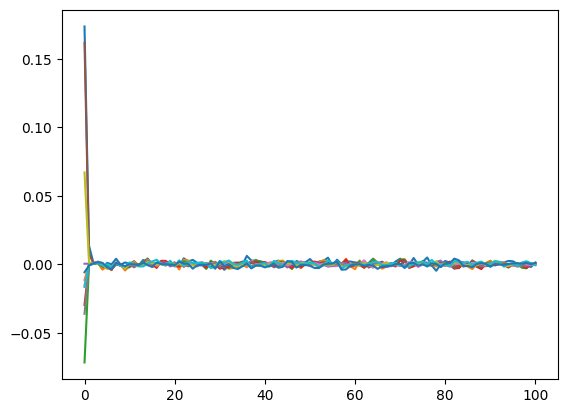

In [224]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


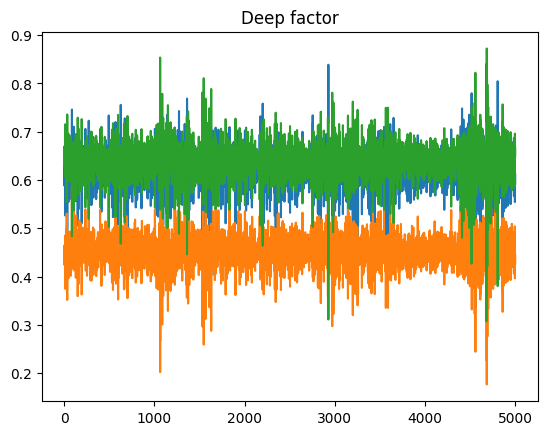

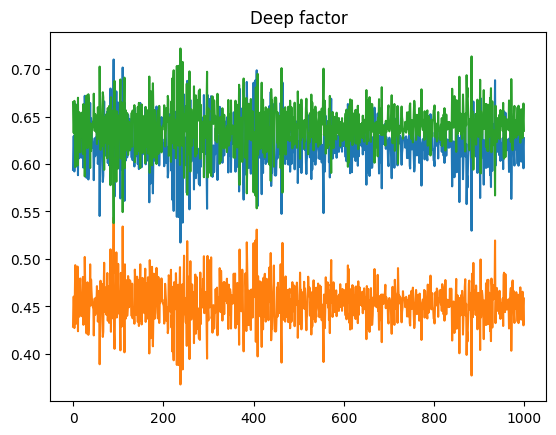

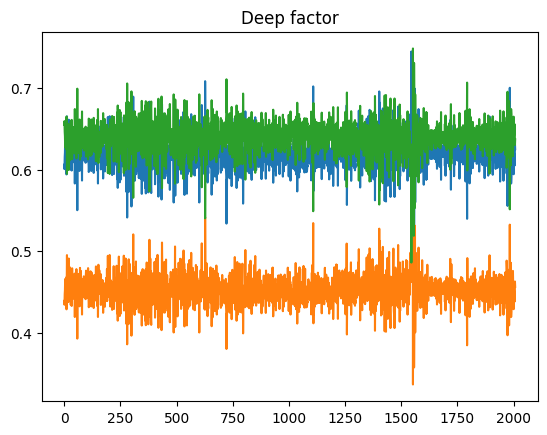

In [239]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)
f_hat = mod.enc(torch.Tensor(y_use).float()).detach().numpy()


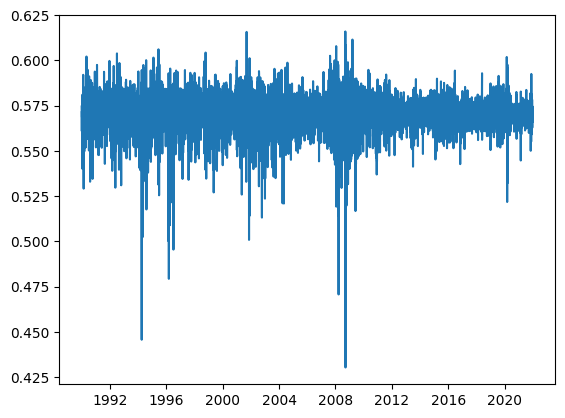

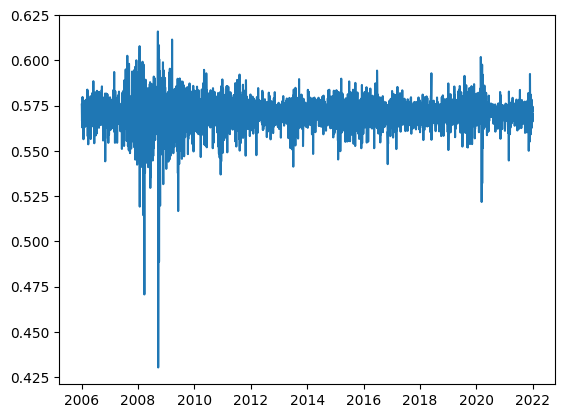

In [242]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(mod, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(jac.shape[0]):
            for i in range(jac.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

CI = computeCI(mod, f_hat)

plt.plot(index,CI)
plt.figure()
flip = False
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


<Axes: >

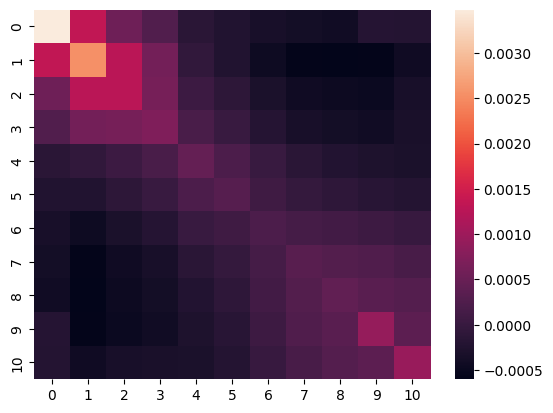

In [253]:
import seaborn as sns
sns.heatmap(errorProcess.cov)

<Axes: >

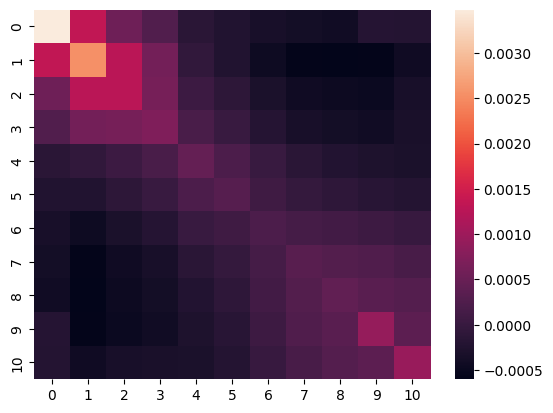

In [258]:
import seaborn as sns
sns.heatmap(obs_cov)

In [259]:
y_train.shape

(5000, 11)

In [261]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
obs_cov = errorProcess.cov

from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y_train).float()).detach().numpy()
resid = y_train - y_hat
obs_cov = np.cov(resid.T)

dim_x = cfg.factor_dim
dim_z = y_train.shape[1]
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(np.where(errorProcess.cov < 0, 0.0, errorProcess.cov)))
ekf.R = np.diag(np.diag(obs_cov))

#ekf.Q = res.sigma_u
ekf.F = res.params[:-1]
ekf.P = res.sigma_u
ekf.x = f_train_hat[-1]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.figure()
i = np.argwhere(index > '2006').min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.figure()
flip = True
CI_filtered = computeCI(F, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.figure()
plt.plot(index, np.stack(zs));


ValueError: operands could not be broadcast together with shapes (13,) (11,) 

1-step ahead  FMSE on the test set: 0.0013153128570419597


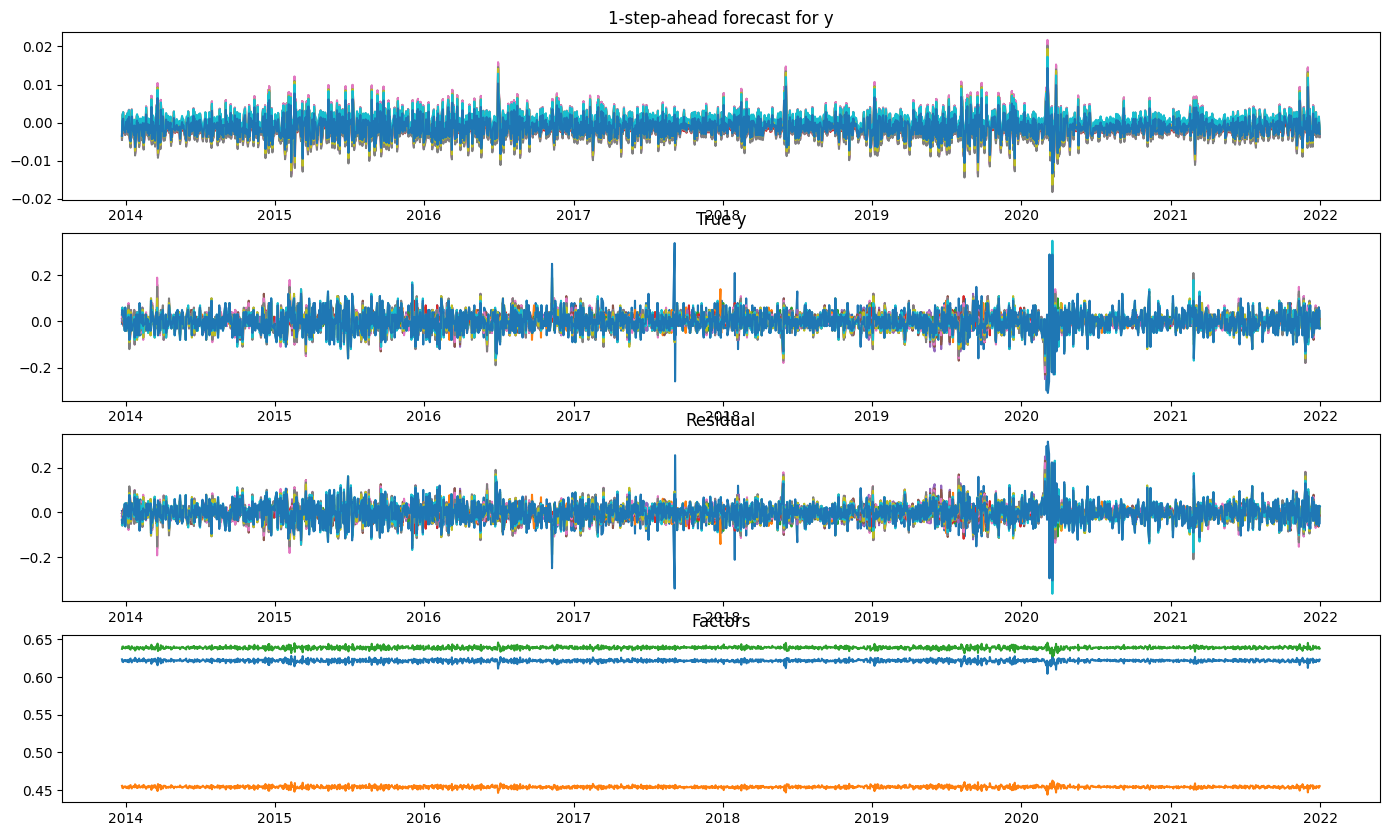

In [227]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()


f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(4,1, figsize=(17,10))
ax[0].plot(index[-cfg.T_test:], y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(index[-cfg.T_test:], y_test);
ax[1].set_title('True y');
ax[2].plot(index[-cfg.T_test:], y_test_pred - y_test);
ax[2].set_title('Residual');
ax[3].plot(index[-cfg.T_test:], f_test_pred);
ax[3].set_title('Factors');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

1-step ahead  FMSE on the test set: 0.0013001680714694968


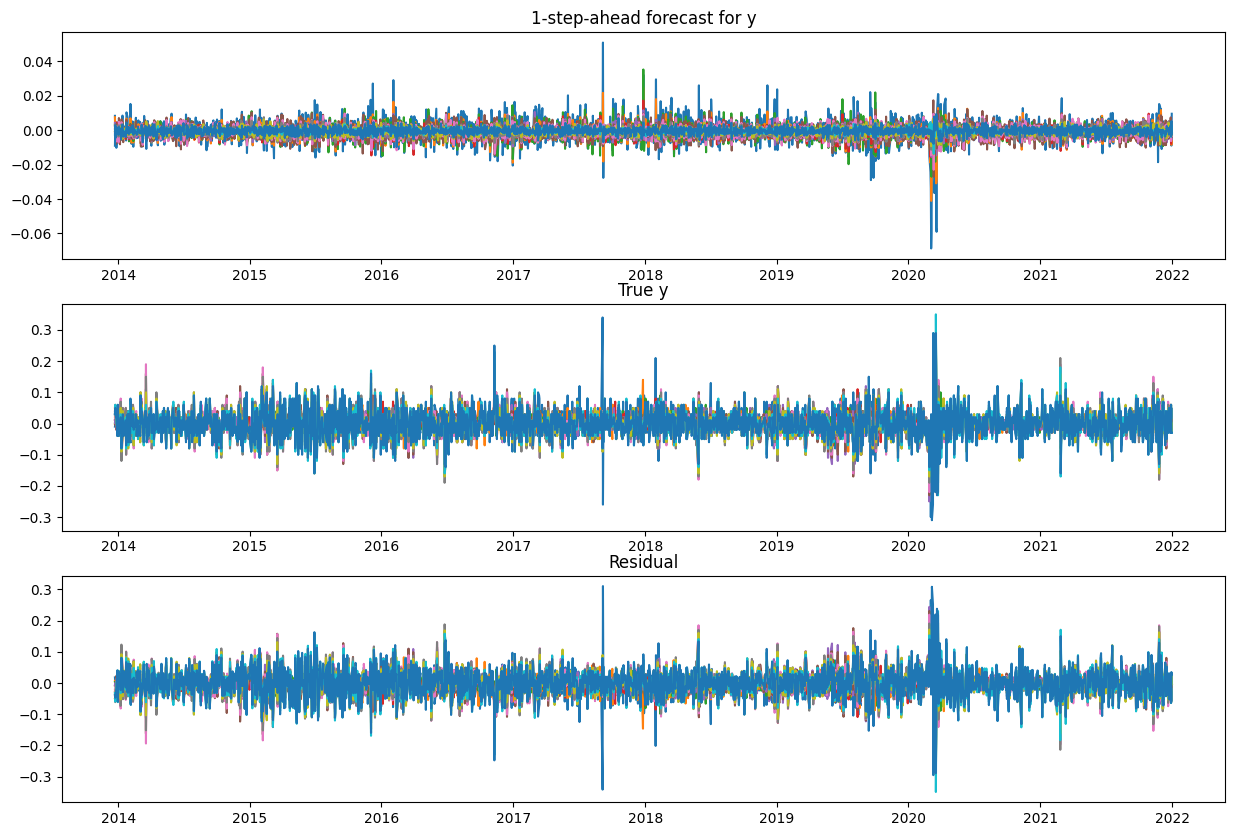

In [228]:
model_bm = VAR(np.concatenate([y_train, y_val]))
res = model_bm.fit(maxlags=1)
test_model = VAR(np.concatenate([y_train, y_val, y_test]))
y_test_pred_bm = test_model.predict(res.params)[-cfg.T_test:]

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(index[-cfg.T_test:], y_test_pred_bm);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(index[-cfg.T_test:], y_test);
ax[1].set_title('True y');
ax[2].plot(index[-cfg.T_test:], y_test_pred_bm - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred_bm-y_test)**2)}")